## Remaining Write-up Sections
- ~~Introduction/outline of methods section~~
- Descriptions of exploratory analysis section (scatter plots and ggpairs)
- Descriptions of modelling section (single and multi knn and linear regression)
- Discussion section (see outline below)
- References (see outline below)

In [17]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(DBI)
library(dbplyr)
library(GGally)
options(repr.matrix.max.rows = 10)

# Predicting the Win Rate of Tennis Players  
<img align="left" src="https://images.unsplash.com/photo-1554068865-24cecd4e34b8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8dGVubmlzfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60" width="1000" />  

*Source: https://unsplash.com/photos/WqI-PbYugn4*

# Introduction<img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />   


### Background 

Tennis is a popular, competitive sport played around the world.
Tennis can be played in "singles" where there is only one person on each side of the net or "doubles" where there are teams of two. 
It can be played on a variety of surfaces such as grass, clay, or hard court (i.e. like a gym floor).

The association of tennis professionals, or ATP, organizes these tournaments and collects data on the players and the matches that take place.

### Our Question

Based on the career statistics of a tennis player, what will be their win rate?

### Our Dataset

We are using the "Game results for Top 500 Players from 2017-2019" dataset for our analysis. Each row in this dataset represents a singles match between two players. Each row contains player stats (e.g. age, height, rank) and match stats (break points, serve points, double faults etc.). We can use this data to determine the relationship between a player's stats and their win rate for this time period.

*Picture source: https://www.emojipng.com/preview/458725*

# Methods and Results<img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />   

<span style="color:red">
    describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
    your report should include code which:
        loads data from the original source on the web 
        wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
        performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
        creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
        performs the data analysis
        creates a visualization of the analysis 
        note: all tables and figure should have a figure/table number and a legend
</span>

### Outline

We will first transform the dataset of tennis matches into a tidy dataset with only player stats. Next, we will look at the relationships between the different variables and win_rate to choose predictors for our regression models. To answer our predictive question, we will train both KNN and linear regression models and then compare to find the model type and predictors that give the lowest error. Once we we have the best model, we will try to predict the win rate for a new player observation.

### Exploring the Data

<span style="color:blue"> **The code below reads the CSV file from the given URL link.** </span>.

In [18]:
## the dataset can be read from the URL link:
atp_data_frame <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
atp_data_frame

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2881,2017-0605,Tour Finals,Hard,8,F,20171113,300,105777,6.0,⋯,54,42,22,15,11,15,6,3650,8,2975
2882,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,1,105676,NA,⋯,53,33,21,14,6,11,7,3775,18,2235
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667


<span style="color:blue"> **The code below cleans and wrangles the raw data set into tidy form by grouping the observations by player. We mutate some statistics to percentages through ratios of the raw variables. We then obtain each player's "career stats" by joining observations in both winning and losing rounds to the player ID. This forms a data frame with each row representing an individual player.** </span>

In [19]:
# calculate player wins and mean match stats for winning matches
player_wins <- atp_data_frame %>%
    group_by(player_id = winner_id) %>%
    summarize(w_height = mean(winner_ht, na.rm =TRUE),
              w_breakpoint_saved_pct = mean(w_bpSaved/w_bpFaced, na.rm =TRUE),
              w_second_serve_win_pct = mean(w_2ndWon / w_svpt,na.rm =TRUE),
              w_first_serve_pct = mean(w_1stWon / w_1stIn,na.rm =TRUE),
              w_first_serve_win_pct = mean(w_1stWon / w_svpt, na.rm = TRUE),
              n_wins = n(),
              mean_age_w  = mean(winner_age),
              mean_rank_points_w = mean(winner_rank_points),
              w_ace_point_pct = mean(w_ace/w_svpt,na.rm = TRUE)
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# calculate player losses and mean match stats for losing matches
player_lose <- atp_data_frame %>%
    group_by(player_id = loser_id) %>%
    summarize(l_height = mean(loser_ht, na.rm =TRUE),
              l_breakpoint_saved_pct = mean(l_bpSaved/l_bpFaced, na.rm =TRUE),
              l_second_serve_win_pct = mean(l_2ndWon / l_svpt,na.rm =TRUE),
              l_first_serve_pct = mean(l_1stWon / l_1stIn,na.rm =TRUE),
              l_first_serve_win_pct = mean(l_1stWon / l_svpt, na.rm = TRUE),
              n_lose = n(),
              mean_age_l  = mean(loser_age),
              mean_rank_points_l = mean(loser_rank_points),
              l_ace_point_pct = mean(l_ace/l_svpt,na.rm = TRUE)
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# join datasets for wins and losses using unique player ids
player_join <- left_join(player_wins, player_lose, by = NULL, copy = TRUE)

# calculate career stats for all player matches
player_career <- player_join %>%
    mutate(height = (w_height + l_height)/2,
          breakpoint_saved_pct = (w_breakpoint_saved_pct+l_breakpoint_saved_pct)/2,
          second_serve_win_pct = (w_second_serve_win_pct+l_second_serve_win_pct)/2,
          first_serve_pct = (w_first_serve_pct+l_first_serve_pct)/2,
          first_serve_win_pct = (w_first_serve_win_pct + l_first_serve_win_pct)/2,
          win_rate = (n_wins/(n_lose+n_wins)*100),
          age = (mean_age_w + mean_age_l) /2,
          mean_rank_points = (mean_rank_points_w + mean_rank_points_l)/2,
          ace_point_pct = (w_ace_point_pct+l_ace_point_pct)/2) %>%
    select(player_id,height,breakpoint_saved_pct,second_serve_win_pct,first_serve_pct,first_serve_win_pct, win_rate,age,mean_rank_points,ace_point_pct) %>%
    drop_na()
player_career

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "player_id"



player_id,height,breakpoint_saved_pct,second_serve_win_pct,first_serve_pct,first_serve_win_pct,win_rate,age,mean_rank_points,ace_point_pct
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100644,198,0.5592240,0.1700660,0.7351579,0.4788888,69.34673,21.15730,4281.6435,0.11124906
103333,208,0.7024075,0.1934502,0.8336761,0.5415601,41.02564,39.12084,962.8682,0.23093646
103819,185,0.6093525,0.2114465,0.7770562,0.4895284,84.17722,37.09069,6720.2910,0.10225660
103852,188,0.6435922,0.2029322,0.7678518,0.4570213,47.11538,36.59486,1064.2837,0.13948328
103893,183,0.6032682,0.2086046,0.7053554,0.4156136,34.56790,36.00516,929.3494,0.05544316
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
106071,193,0.6247593,0.1647858,0.7115762,0.4748335,36.06557,25.58023,653.8502,0.10261438
106233,185,0.5928571,0.2059738,0.7307146,0.4397496,69.26829,24.73736,4010.7090,0.07383174
106296,183,0.5769397,0.1768606,0.6743243,0.4253424,33.33333,25.12377,458.3750,0.07423463


<span style="color:blue"> **The code below splits the player career dataset into testing and training sets, which are necessary for model tuning and evaluation.** </span>

In [20]:
# split the data set into training and testing set. The following exploratory data analysis uses only the training set
set.seed(20)
player_split <- initial_split(player_career, prop = 0.75, strata = win_rate)
player_train <- training(player_split)
player_test <- testing(player_split)

<span style="color:blue">**The table below contains the mean of each quantitative variable in the training set. This gives an idea of the average statistics for a given player, which is relevant for exploratory data analysis. It tells us what sort of values (or percentages) we can expect for each stat.** </span>

In [21]:
# exploratory data analysis table:

# the means of the predictor variables we plan to use in our analysis
exploratory_data_analysis_table <- player_train %>%
    select(-player_id) %>%
    map_df(mean, na.rm = TRUE)
exploratory_data_analysis_table

height,breakpoint_saved_pct,second_serve_win_pct,first_serve_pct,first_serve_win_pct,win_rate,age,mean_rank_points,ace_point_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
186.0253,0.5947108,0.1958433,0.7193289,0.44232,45.90908,30.0706,1208.705,0.07991921


<span style="color:blue"> **The code below produces a visualization which is also very useful in our exploratory data analysis. By using the function `ggpairs`, we can see the "big picture" of all the relationships between each pair of variables. This visualization helps us pick variables which have a relatively strong relationship with win rate, and thus will be effective in predictions.** </span>

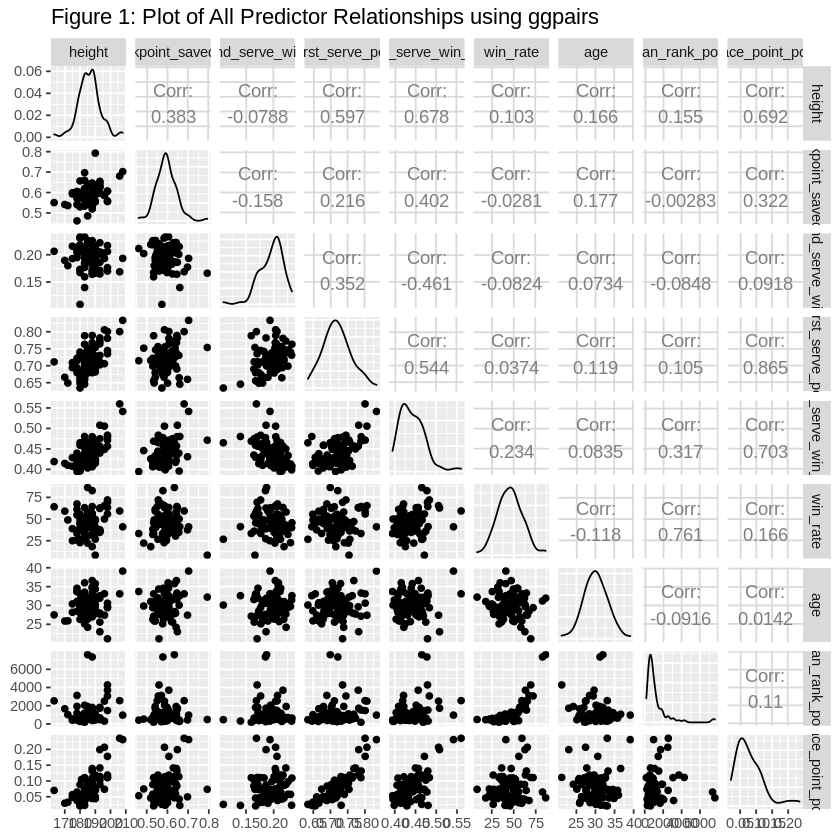

In [22]:
player_ggpairs <- player_train %>%
    select(-player_id) %>%
    ggpairs(title = "Figure 1: Plot of All Predictor Relationships using ggpairs")

player_ggpairs

### Model Selection

<span style="color:blue"> **The first option for our model is K-NN regression for *individual predictors* with win_rate as the target. In order to simplify the steps, we use a for loop to run the model on each predictor. The result is a table with 3 columns: the predictor, the best k value (as chosen through cross validation), and the RMSPE.** </span> 

<span style="color:red">**Warning! The for_loop iteration may take time.** </span>

In [23]:
set.seed(1)

predictors <- c(
    'height','breakpoint_saved_pct','second_serve_win_pct','first_serve_pct','first_serve_win_pct','age','mean_rank_points','ace_point_pct'
)

results <- tibble()
results <- mutate(results, predictor = "", best_k = 0, rmspe = 0)

for (pred in predictors) {

    print(pred)
    
    train_data <- player_train %>%
        select(win_rate, all_of(pred))
    
    test_data <- player_test %>%
        select(win_rate, all_of(pred))
    
    tennis_recipe <- recipe(win_rate ~ ., data = train_data) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())
    
    tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("regression")
    
    tennis_vfold <- vfold_cv(train_data, v = 5, strata = win_rate)
    
    tennis_workflow <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_spec)
    
    gridvals <- tibble(neighbors = seq(1,40))
    
    tennis_results <- tennis_workflow %>%
       tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
       collect_metrics() %>%
       filter(.metric == "rmse") %>%
       filter(mean == min(mean))
    
    kmin <- pull(tennis_results, neighbors)
    
    tennis_spec_kmin <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
       set_engine("kknn") %>%
       set_mode("regression")
    
    tennis_fit <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_spec_kmin) %>%
       fit(data = train_data)
    
    rmspe_val <- tennis_fit %>%
       predict(test_data) %>%
       bind_cols(test_data) %>%
       metrics(truth = win_rate, estimate = .pred) %>%
       filter(.metric == "rmse") %>%
       select(.estimate) %>%
       pull()
    
    
    results <- results %>%
        add_row(predictor = pred, best_k=kmin, rmspe = rmspe_val)
    
}

print("Table 1: RMSPE and Best K Values for Single Predictor Models")
results %>% arrange(rmspe)

[1] "height"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "breakpoint_saved_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "second_serve_win_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "first_serve_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "first_serve_win_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "age"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "mean_rank_points"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "ace_point_pct"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "Table 1: RMSPE and Best K Values for Single Predictor Models"


predictor,best_k,rmspe
<chr>,<dbl>,<dbl>
mean_rank_points,7,10.24509
first_serve_win_pct,36,15.55832
height,37,15.89049
first_serve_pct,28,16.09443
age,39,16.23855
breakpoint_saved_pct,33,16.26547
second_serve_win_pct,32,16.31776
ace_point_pct,5,17.91994


<span style="color:blue"> **The second option is K-NN regression for *combined predictors* with win_rate as the target. The combined predictors are chosen from the strongest relationships we observed in player_ggpairs. Again, we iterate with a for loop to reduce the amount of code. The resulting table contains the same 3 columns as the individual predictors.** 

</span> <span style="color:red"> **Warning! The for_loop iteration may take time.** </span>

In [24]:
set.seed(1)

formulas <- c(
"win_rate ~ mean_rank_points + first_serve_win_pct",
"win_rate ~ mean_rank_points + height",
"win_rate ~ mean_rank_points + first_serve_pct",
"win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct",
"win_rate ~ mean_rank_points + first_serve_pct + height"    
)

multi_results <- tibble()
multi_results <- mutate(multi_results, predictor = "", best_k = 0, rmspe = 0)

for (f in formulas) {
    
    print(as.formula(f))
    
    tennis_recipe_multiple <- recipe(as.formula(f), data = player_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

    tennis_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("regression")
    
    tennis_vfold_mul <- vfold_cv(player_train, v = 5, strata = win_rate)
    
    tennis_workflow_multiple <- workflow() %>%
       add_recipe(tennis_recipe_multiple) %>%
       add_model(tennis_spec_mul)
    
    gridvals_mul <- tibble(neighbors = seq(1,40))
    
    tennis_results_multiple <- tennis_workflow_multiple %>%
       tune_grid(resamples = tennis_vfold_mul, grid = gridvals_mul) %>%
       collect_metrics() %>%
       filter(.metric == "rmse")
    if(f == "win_rate ~ mean_rank_points + first_serve_win_pct") {
    best_plot <- ggplot(tennis_results_multiple,aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "K", y = "RMSPE") + 
        ggtitle("Figure 2: K vs RMSPE for mean rank points and first serve win %") + 
        theme(text = element_text(size = 20))
    }
    tennis_result_min <-  tennis_results_multiple %>%
       filter(mean == min(mean))
    
    kmin_multiple <- pull(tennis_result_min, neighbors)
    
    kmin_multiple
    
    tennis_spec_kmin_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_multiple) %>%
       set_engine("kknn") %>%
       set_mode("regression")
    
    tennis_fit_multiple <- workflow() %>%
       add_recipe(tennis_recipe_multiple) %>%
       add_model(tennis_spec_kmin_mul) %>%
       fit(data = player_train)
    
    rmspe_val_mul <- tennis_fit_multiple %>%
       predict(player_test) %>%
       bind_cols(player_test) %>%
       metrics(truth = win_rate, estimate = .pred) %>%
       filter(.metric == "rmse") %>%
       select(.estimate) %>%
       pull()
    
    multi_results <- multi_results %>%
        add_row(predictor = f, best_k = kmin_multiple, rmspe = rmspe_val_mul)
}

print("Table 2: RMSPE and Best K Values for Multi Predictor Models")
multi_results %>%
    arrange(rmspe)

win_rate ~ mean_rank_points + first_serve_win_pct


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


win_rate ~ mean_rank_points + height


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


win_rate ~ mean_rank_points + first_serve_pct


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


win_rate ~ mean_rank_points + first_serve_pct + height


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "Table 2: RMSPE and Best K Values for Multi Predictor Models"


predictor,best_k,rmspe
<chr>,<dbl>,<dbl>
win_rate ~ mean_rank_points + first_serve_win_pct,6,8.53232
win_rate ~ mean_rank_points + first_serve_pct,4,9.11855
win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct,2,10.46228
win_rate ~ mean_rank_points + height,4,10.46816
win_rate ~ mean_rank_points + first_serve_pct + height,2,11.78315


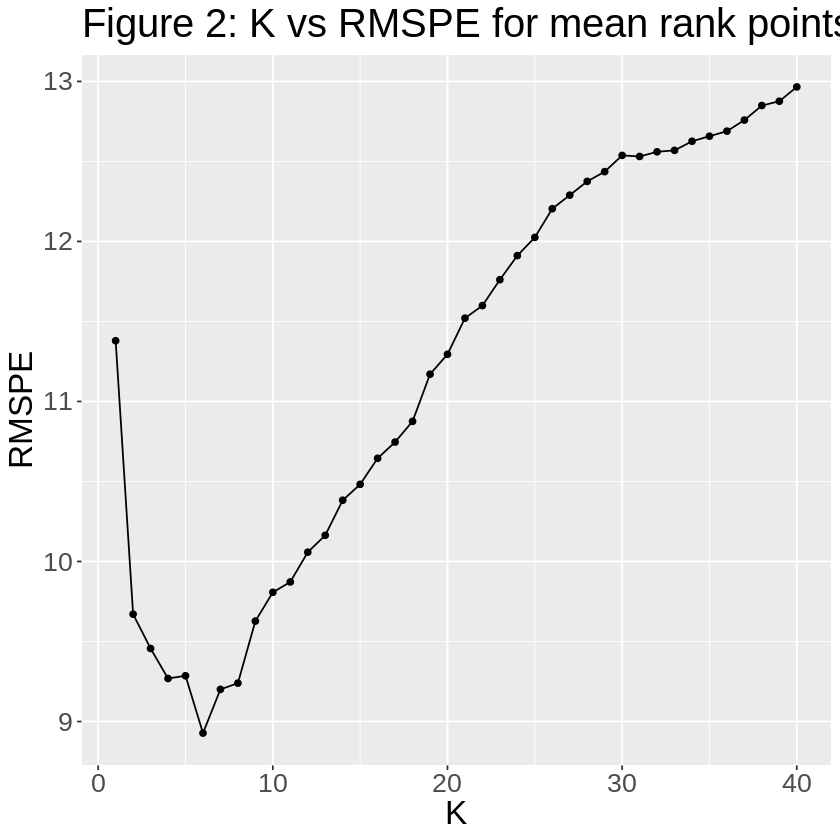

In [25]:
best_plot

<span style="color:blue"> **The third option is linear regression for *individual predictors* with win_rate as the target. Again, we iterate with a for loop to reduce the amount of code. The resulting table has only 2 columns this time: the predictor and the RMSPE. Since the model is using linear regression, there is no k-value.** 

</span> <span style="color:red"> **Warning! The for_loop iteration may take time.** </span>

In [26]:
set.seed(1)

formulas <- c(
"win_rate ~ mean_rank_points + first_serve_win_pct",
"win_rate ~ mean_rank_points + height",
"win_rate ~ mean_rank_points + first_serve_pct",
"win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct",
"win_rate ~ mean_rank_points + first_serve_pct + height"    
)

multi_lm_results <- tibble()
multi_lm_results <- mutate(multi_lm_results, lm_predictor = "", lm_rmspe = 0)

for (f in formulas) {

    print(f)
    
    tennis_spec_lm <- linear_reg() %>%
        set_engine("lm") %>%
        set_mode("regression")
    
    tennis_recipe_lm <- recipe(as.formula(f), data = player_train)
    
    tennis_fit_lm <- workflow() %>%
        add_recipe(tennis_recipe_lm) %>%
        add_model(tennis_spec_lm) %>%
        fit(data = player_train)
    
    lm_rmspe_val <- tennis_fit_lm %>%
        predict(player_test) %>%
        bind_cols(player_test) %>%
        metrics(truth = win_rate, estimate = .pred) %>%
        filter(.metric == "rmse") %>%
        select(.estimate) %>%
        pull()

    multi_lm_results <- multi_lm_results %>%
        add_row(lm_predictor = f, lm_rmspe = lm_rmspe_val)

}

print("Table 2: RMSPE for Single Variable Linear Regression")
multi_lm_results %>%
    arrange(lm_rmspe)

[1] "win_rate ~ mean_rank_points + first_serve_win_pct"
[1] "win_rate ~ mean_rank_points + height"
[1] "win_rate ~ mean_rank_points + first_serve_pct"
[1] "win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct"
[1] "win_rate ~ mean_rank_points + first_serve_pct + height"
[1] "Table 2: RMSPE for Single Variable Linear Regression"


lm_predictor,lm_rmspe
<chr>,<dbl>
win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct,9.643020
win_rate ~ mean_rank_points + first_serve_pct,9.699788
win_rate ~ mean_rank_points + first_serve_pct + height,9.710520
win_rate ~ mean_rank_points + height,9.723320
win_rate ~ mean_rank_points + first_serve_win_pct,9.761017


<span style="color:blue"> **Finally, the last option is linear regression for *combined predictors* with win_rate as the target. Again, we iterate with a for loop to reduce the amount of code. The result is presented by a table with 2 columns.** 

</span> <span style="color:red"> **Warning！the for_loop iteration may take time.** </span>

In [27]:
set.seed(1)

formulas <- c(
"win_rate ~ mean_rank_points + first_serve_win_pct",
"win_rate ~ mean_rank_points + height",
"win_rate ~ mean_rank_points + first_serve_pct",
"win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct",
"win_rate ~ mean_rank_points + first_serve_pct + height"    
)

multi_lm_results <- tibble()
multi_lm_results <- mutate(multi_lm_results, lm_predictor = "", lm_rmspe = 0)

for (f in formulas) {

    print(f)
    
    tennis_spec_lm <- linear_reg() %>%
        set_engine("lm") %>%
        set_mode("regression")
    
    tennis_recipe_lm <- recipe(as.formula(f), data = player_train)
    
    tennis_fit_lm <- workflow() %>%
        add_recipe(tennis_recipe_lm) %>%
        add_model(tennis_spec_lm) %>%
        fit(data = player_train)
    
    lm_rmspe_val <- tennis_fit_lm %>%
        predict(player_test) %>%
        bind_cols(player_test) %>%
        metrics(truth = win_rate, estimate = .pred) %>%
        filter(.metric == "rmse") %>%
        select(.estimate) %>%
        pull()

    multi_lm_results <- multi_lm_results %>%
        add_row(lm_predictor = f, lm_rmspe = lm_rmspe_val)

}
print("Table 2: RMSPE for Multi-vBariable Linear Regression")
multi_lm_results %>%
    arrange(lm_rmspe)

[1] "win_rate ~ mean_rank_points + first_serve_win_pct"
[1] "win_rate ~ mean_rank_points + height"
[1] "win_rate ~ mean_rank_points + first_serve_pct"
[1] "win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct"
[1] "win_rate ~ mean_rank_points + first_serve_pct + height"
[1] "Table 2: RMSPE for Multi-vBariable Linear Regression"


lm_predictor,lm_rmspe
<chr>,<dbl>
win_rate ~ mean_rank_points + first_serve_pct + first_serve_win_pct,9.643020
win_rate ~ mean_rank_points + first_serve_pct,9.699788
win_rate ~ mean_rank_points + first_serve_pct + height,9.710520
win_rate ~ mean_rank_points + height,9.723320
win_rate ~ mean_rank_points + first_serve_win_pct,9.761017


### Using the Model

<span style="color:blue"> **Following our testing of the many potential models, the one that produces the lowest RMSPE is:**
- K-NN regression with mean rank points and first serve win percentage as predictors
- k = 6

<span style="color:blue">**Therefore, this is what we will use to predict win rate.**</span>

In [28]:
set.seed(1)

tennis_recipe_final <- recipe(win_rate ~ mean_rank_points + first_serve_win_pct, data = player_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_model_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
    set_engine("kknn") %>%
    set_mode("regression")

tennis_fit_final <- workflow() %>%
    add_recipe(tennis_recipe_final) %>%
    add_model(tennis_model_final) %>%
    fit(data = player_train)

<span style="color:blue"> **Now, we can try testing the model for a new player.** </span>

In [29]:
new_player <- tibble(mean_rank_points = 1400, first_serve_win_pct = 0.46, age = 29)

prediction <- predict(tennis_fit_final, new_player) %>%
    bind_cols(new_player) %>%
    rename(predicted_win_rate = .pred)
prediction

predicted_win_rate,mean_rank_points,first_serve_win_pct,age
<dbl>,<dbl>,<dbl>,<dbl>
52.5721,1400,0.46,29


# Discussion <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />  

<div style="color:red"> summarize what you found </div>

Overall, we found that a player's "mean rank points" and "first serve win %" are good predictors for estimating a player's win rate. Using these variables, we trained a KNN regression model that had RMSPE of only 8.53. This RMSPE is lower compared to a linear regression model using the same predictors.

<div style="color:red"> discuss whether this is what you expected to find? </div>

This result makes sense because a player that has lots of rank points and a strong serve is likely to win more games. The RMSPE differences between the KNN model and linear regression models was also expected because we observed a non-linear relationship between rank points and win rate.  We used our model to predict the win rate for a player with 1400 rank points and a first serve win % of 46%. The outcome was approximately what we would expect for such an above average player based on the mean stats we calculated above.

<div style="color:red"> discuss what impact could such findings have? </div>

Our model can be used to predict the performance of tennis player using only a few statistics... 

<div style="color:red"> discuss what future questions could this lead to? </div>




 There are many components involved in the game of tennis and that is reflected in the 50 columns of this raw data set. These variables contribute to whether a player wins or loses a match and affects that player's overall win rate. By mutating the data into nine predictors we can set a KNN regression model to predict a player's career win rate. The predictors include:


| Variable                        | Explanation                                                                                         |
|---------------------------------|-----------------------------------------------------------------------------------------------------|
| Age (years)                     | Older players will have sustained more injuries and be less fit.                                    |
| Height (cm)                     | Height can provide an advantage when serving.                                                       |
| Serve Points that were Aces (%) | Winning points on a serve indicates a strong serve.                                                 |
| First Serves (%)                | The ratio of "first serve points" to "first serves made in" means a player's serve is more accurate |
| First Serves Won (%)            | Strong and accurate first serves will lead to fewer double faults.                                  |
| Second Serves Won (%)           | Strong second serves means fewer lost points due to a slow serve.                                   |
| Double Faults per Game (ratio)  | Fewer double faults per game indicates accurate serving.                                            |
| Breakpoints Saved (%)           | Preventing breaks means a player wins the important points for winning the match                    |
| Rank Points                     | Awarded to players by the ATP for winning matches                                                   |

The KNN regression model will need to be trained, evaluated, and tuned with training and testing sets before predicting a win rate on a new player. By organizing a data set to keep track of both the K and RMSE (Root Mean Square Error) values calculated, we will be able to visualize how each predictor affects the player's win rate. We can then further analyze which combination of predicators, if any, will yield the lowest test error resulting in a better ability to predict a player's win rate.

We expect that the estimated win rate will reflect the respective career stats of the player. For example, if they have impressive stats, such as a high "breakpoint save percentage" and high "rank points", then their win rate will be high. Conversely, if our player has poor stats, their win rate will reflect this and be lower. 

Predicting the approximate win rate of a given player could be useful in a number of applications. For one, it could be used to get a sense of how the player will perform in the future. In other words, with the knowledge of their win rate, one can make a rough estimate of a player's chances in an upcoming tournament or season. Additionally, as the win rate is based on existing stats, it can be used to provide a clearer estimate of the result of a head-to-head match. 

This analysis could also prompt further questions:
 - Are there stats not included in the dataset that could improve the effectiveness of the model?
 - Do certain stats influence win rate more, and if so, is there a better weight function to use in the regression engine?


# References <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" /> 


<div style="color:red">     At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references). </div>
<div style="color:red">     Make sure to cite the source of your data as well. </div>


Keith Prowse Editors. “Love? Ace? Tennis Terminology Explained: Tennis Glossary.” *Keith Prowse*, 2019, www.keithprowse.co.uk/news-and-blog/2019/01/02/tennis-terminology-explained/

Timbers et al. \"Data Science: A First Introduction.\" *UBC Data Science*, 2021
\
\
Nag, Utathya. “Tennis Rankings: How They Work and Difference between ATP and Wta Systems.” Tennis Rankings: Everything You Need to Know, International Olympic Committee, 23 Feb. 2021, olympics.com/en/featured-news/tennis-rankings-atp-wta-men-women-doubles-singles-system-grand-slam-olympics. 
\
\
**Data Source:** https://github.com/JeffSackmann/tennis_atp